## <center> Machine Learning Project
## <center> Course: ML1    
#### <center> Instructor: Dr. Tariq Mahmood

### <center> Submitted By:
## <center> Muhammad Uzair 29414
#### <center> MS - Data Science (IBA)


#### <center> Dataset - Bank
https://archive.ics.uci.edu/dataset/222/bank+marketing

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.class_weight import compute_class_weight
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE


# Functions

In [2]:
def load_data(filepath):
    df = pd.read_csv(filepath, sep=';')
    return df

def class_label(df):
    # Assuming your dataset is stored in a variable called 'df'
    df['y'] = df['y'].replace({'yes': 1, 'no': 0})
    return df

def clean_data(df):
    df_cleaned = df.dropna()
    return df_cleaned

def transform_data(df):
    # Select numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    # Check if there are missing values in numerical columns
    if df[numerical_cols].isnull().any().any():
        print("Warning: Missing values found in numerical columns. Impute or remove them.")
    
    # Define preprocessing steps for numerical and categorical columns
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder()
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Define the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    
    # Transform the data
    transformed_data = pipeline.fit_transform(df)
    
    # Get column names after one-hot encoding
    column_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'] \
        .get_feature_names_out(categorical_cols)
    
    # Combine numerical and one-hot encoded categorical columns
    transformed_df = pd.DataFrame(transformed_data, columns=np.concatenate((numerical_cols, column_names)))
    
    return transformed_df

def eda(df):
    summary_stats = df.describe()
    float_cols = df.select_dtypes(include=['float64']).columns
    
    num_cols = len(float_cols)
    num_rows = (num_cols + 2) // 3
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(float_cols):
        plt.subplot(num_rows, 3, i+1)
        sns.histplot(df[col], kde=True)
        plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(float_cols):
        plt.subplot(num_rows, 3, i+1)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


def manual_split(df, target_column):
    if isinstance(target_column, list):
        target_column = target_column[0]
    
    # One-hot encoding for categorical features
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    # Check if the target column is in the list of categorical columns
    if target_column in categorical_cols:
        # Remove the target column from the list of categorical columns
        categorical_cols.remove(target_column)
    # else:
    #     print(f"Target column '{target_column}' is not found in the DataFrame's categorical columns.")
    
    # Perform one-hot encoding excluding the target column
    df = pd.get_dummies(df, columns=categorical_cols)

    # Label encoding for the target variable
    label_encoder = LabelEncoder()
    df[target_column] = label_encoder.fit_transform(df[target_column])

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=[target_column]),
        df[target_column],
        test_size=0.3,
        random_state=1
    )
    return X_train, X_test, y_train, y_test
    
def cv_scores(model,X_train, y_train):  
    # Example: KNN Classifier
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return cv_scores
    
def train_model(model,X_train,y_train):
    model.fit(X_train, y_train)

def evaluate_model(model,X_test,y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)
    
    if len(np.unique(y_test)) > 2:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    else:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    return accuracy, classification_rep, roc_auc

# without CI

## Master Pipeline

In [3]:
def master_pipeline(filepath, target):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train, y_train)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train, y_train)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train, y_train)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")

In [4]:
# file path
filepath = 'bank-full.csv'
target = 'y'

df1 = pd.read_csv(filepath, sep=';')



In [5]:
df1.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

## Logistic Regression

In [6]:
def model_selection():
    model = LogisticRegression()
    print ('Logistic Regression')
    return model

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})
C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


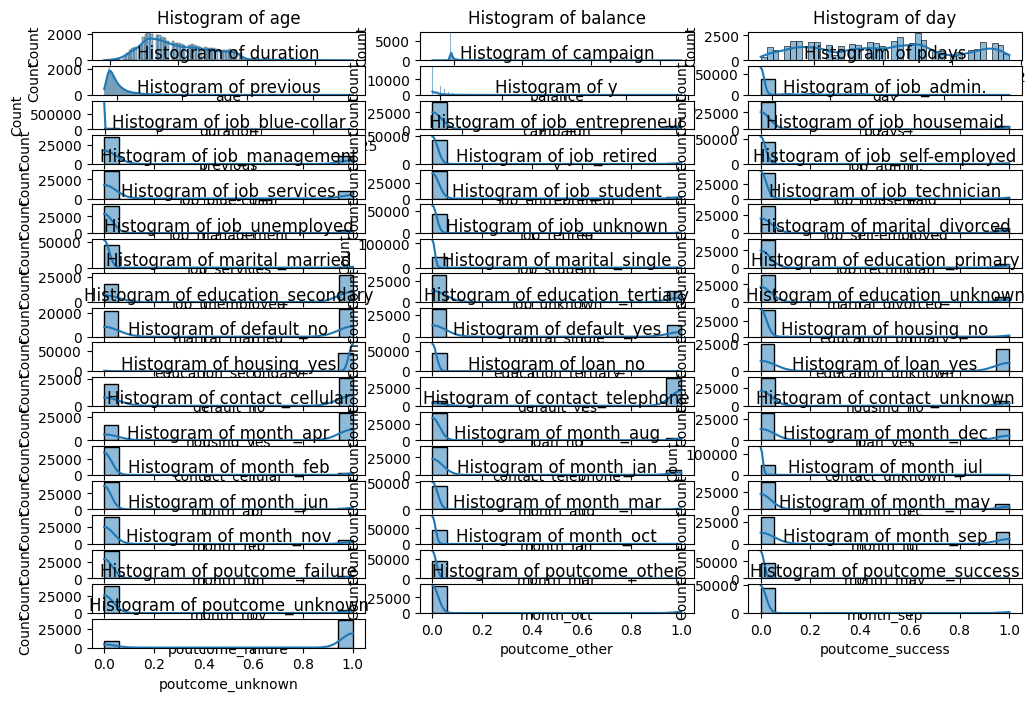

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


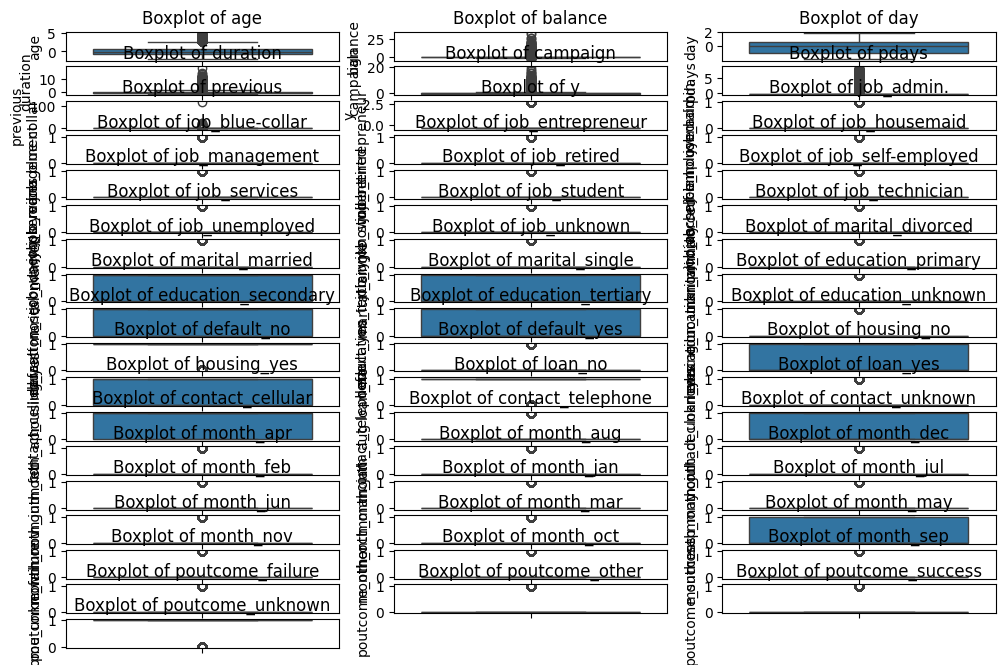

Logistic Regression

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.439
F1 -ve: 0.946
AUC: 0.907
Accuracy: 0.901

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.903
Fold 2: 0.902
Fold 3: 0.899
Fold 4: 0.904
Fold 5: 0.903

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.439
F1 -ve: 0.946
AUC: 0.907
Accuracy: 0.901


In [7]:
master_pipeline(filepath, target)

## Naive Bayes

In [8]:
def model_selection():
    model = GaussianNB()
    print('Naive Bayes')
    return model

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})
C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


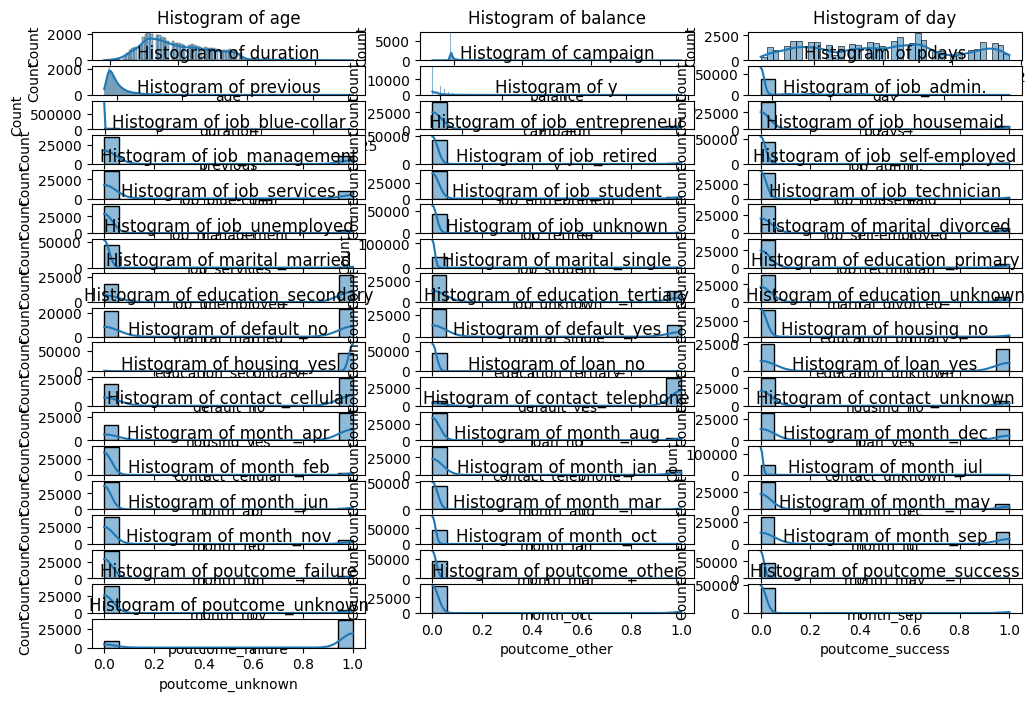

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


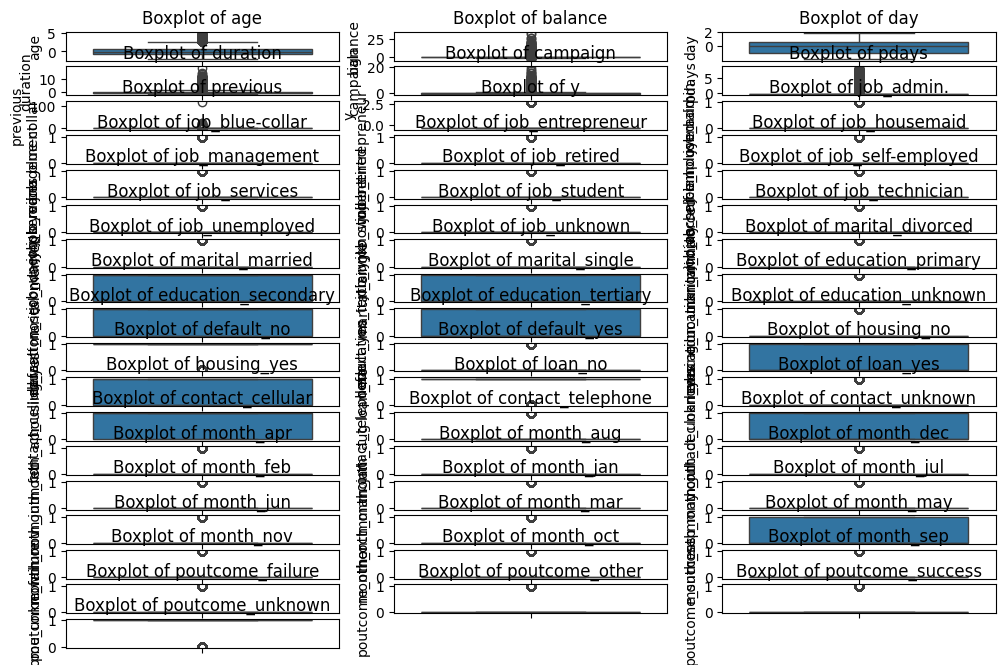

Naive Bayes

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.443
F1 -ve: 0.913
AUC: 0.806
Accuracy: 0.849

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.848
Fold 2: 0.842
Fold 3: 0.852
Fold 4: 0.854
Fold 5: 0.846

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.443
F1 -ve: 0.913
AUC: 0.806
Accuracy: 0.849


In [9]:
master_pipeline(filepath, target)

## Decision Tree

In [10]:
def model_selection():
    model = DecisionTreeClassifier()
    print('Decision Tree')
    return model

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})
C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


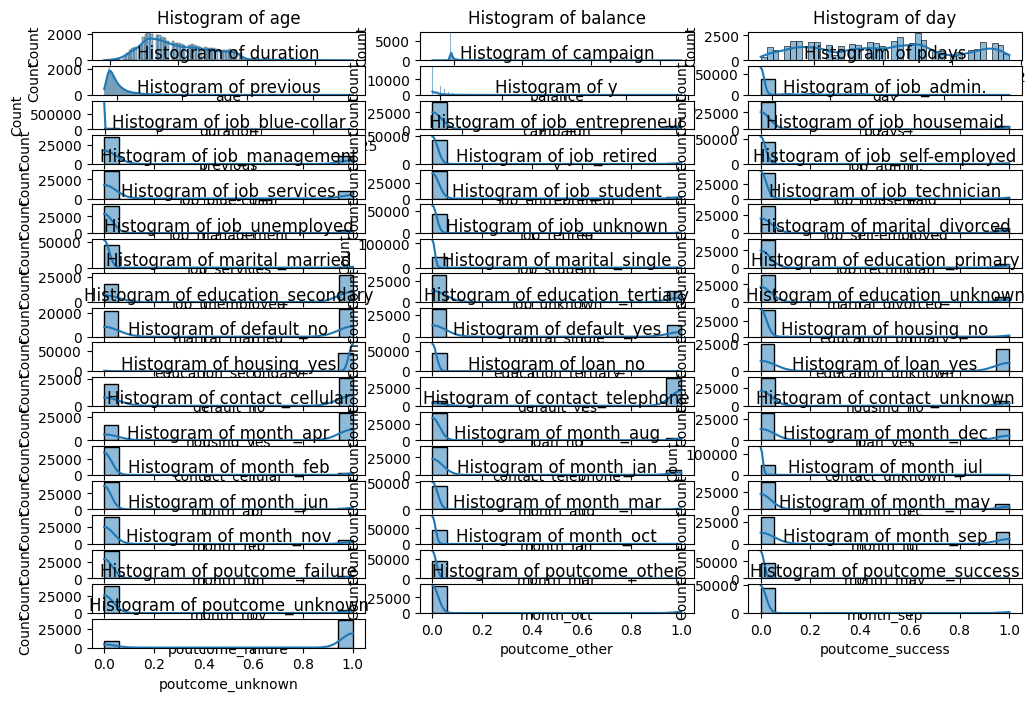

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


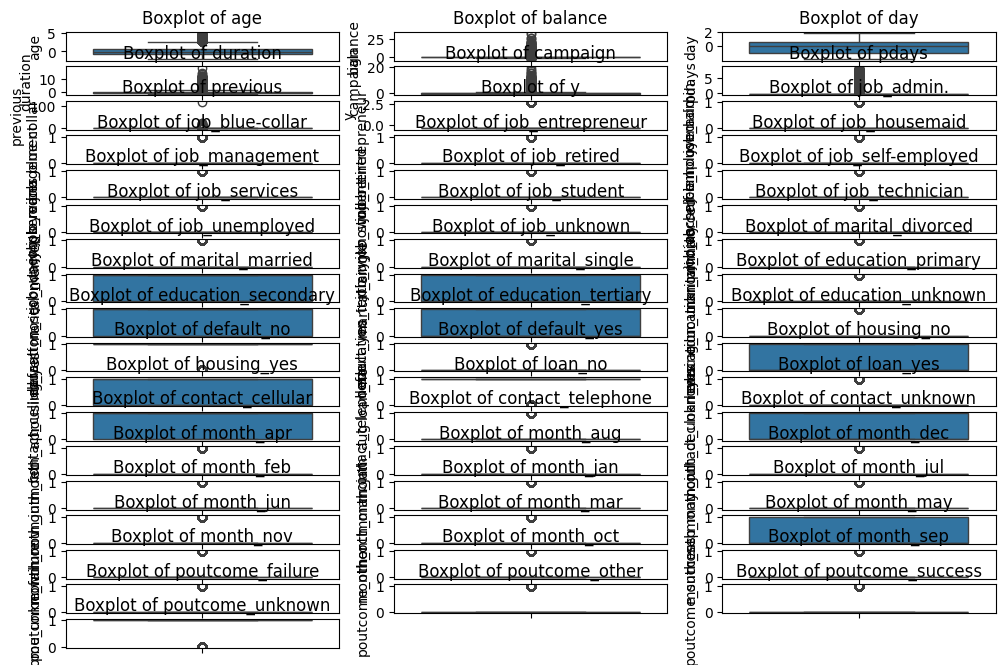

Decision Tree

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.474
F1 -ve: 0.929
AUC: 0.708
Accuracy: 0.875

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.880
Fold 2: 0.876
Fold 3: 0.881
Fold 4: 0.875
Fold 5: 0.868

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.480
F1 -ve: 0.930
AUC: 0.712
Accuracy: 0.877


In [11]:
master_pipeline(filepath,target)

## Random Forest Classifier

In [12]:
def model_selection():
    model = RandomForestClassifier()
    print('Random Forest Classifier')
    return model

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})
C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


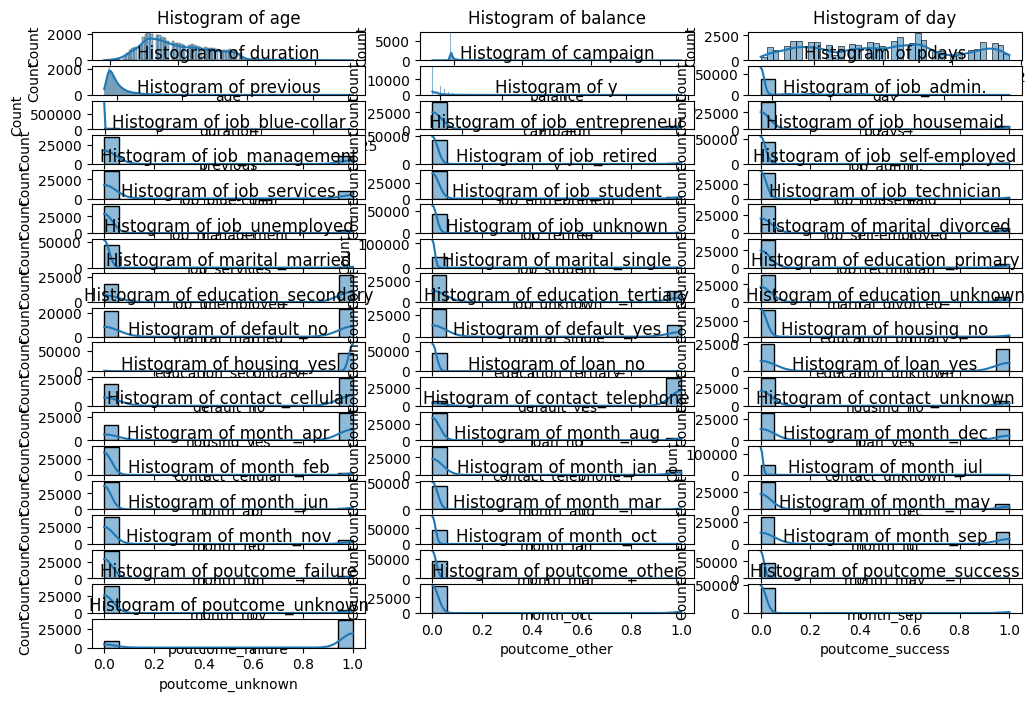

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


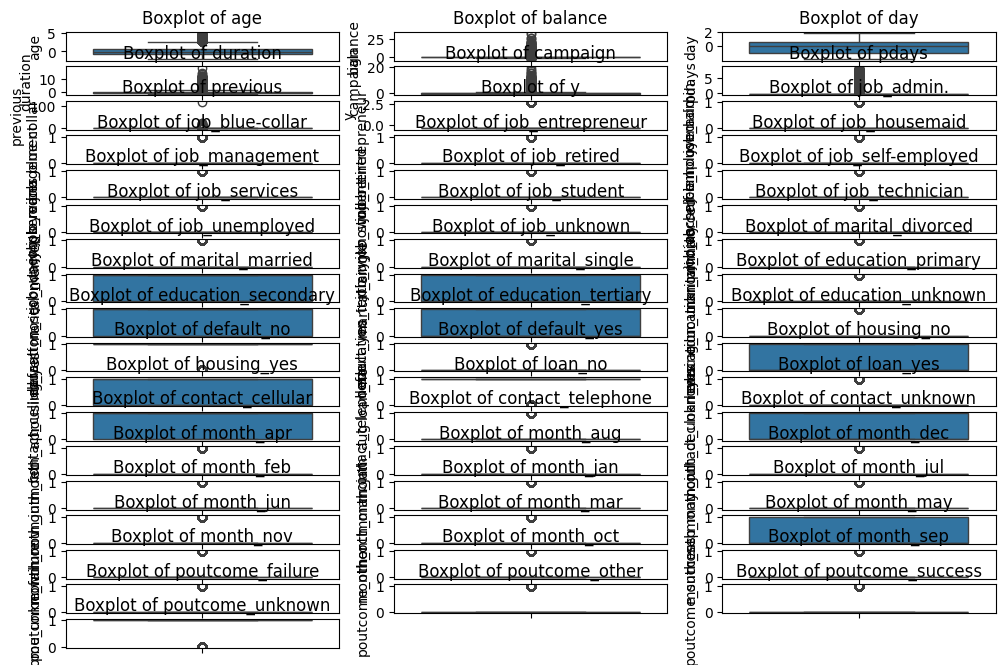

Random Forest Classifier

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.496
F1 -ve: 0.949
AUC: 0.928
Accuracy: 0.907

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.906
Fold 2: 0.902
Fold 3: 0.903
Fold 4: 0.906
Fold 5: 0.904

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.513
F1 -ve: 0.949
AUC: 0.929
Accuracy: 0.908


In [13]:
master_pipeline(filepath, target)

## Gradient Boosting Classifier

In [14]:
def model_selection():
    model = GradientBoostingClassifier()
    print('Gradient Boosting Classifier')
    return model

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})
C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:61: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


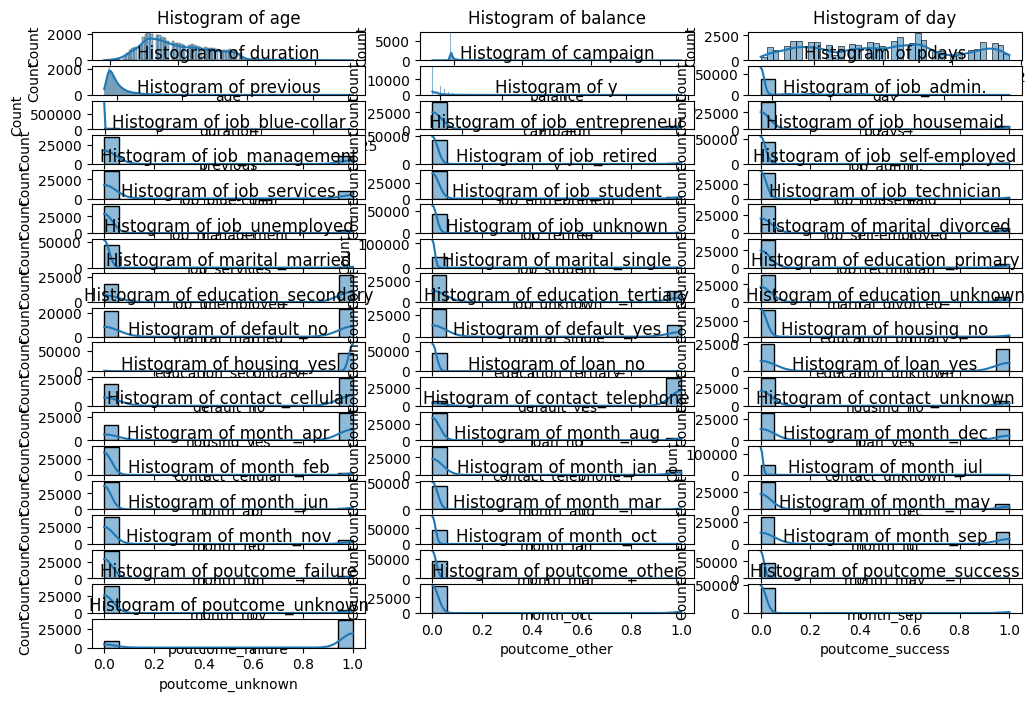

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:69: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


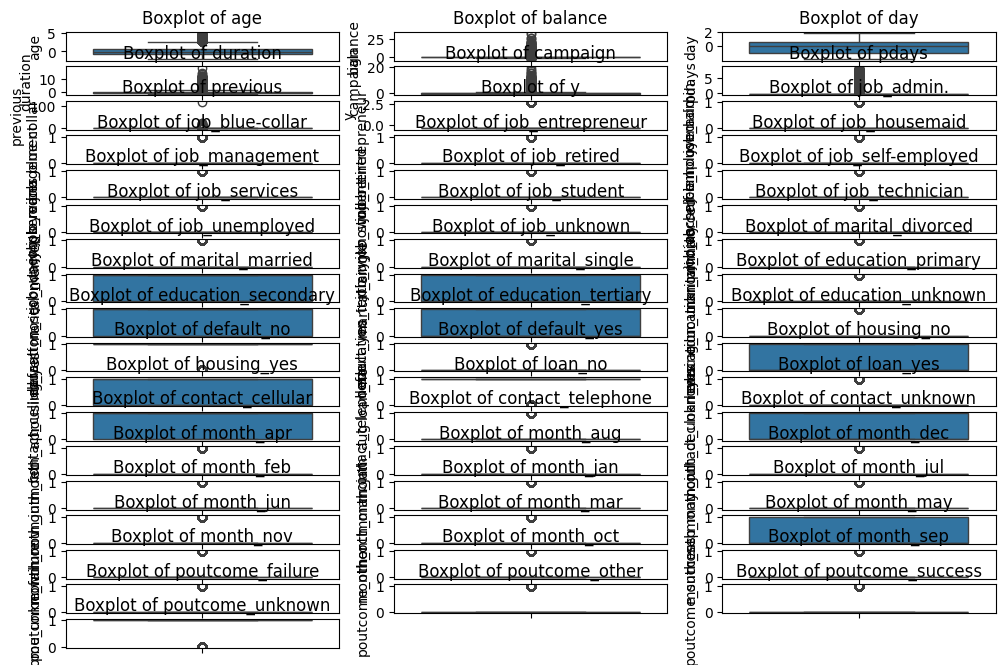

Gradient Boosting Classifier

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.498
F1 -ve: 0.948
AUC: 0.926
Accuracy: 0.906

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.906
Fold 2: 0.903
Fold 3: 0.905
Fold 4: 0.909
Fold 5: 0.906

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.498
F1 -ve: 0.948
AUC: 0.926
Accuracy: 0.906


In [15]:
master_pipeline(filepath, target)

## Results

|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.439               | 0.443       | 0.479         | 0.503                    | 0.498             |
| F1-ve                  | 0.946               | 0.913       | 0.930         | 0.949                    | 0.948             |
| AUC                    | 0.907               | 0.806       | 0.711         | 0.929                    | 0.926             |
| Accuracy               | 0.901               | 0.849       | 0.877         | 0.908                    | 0.906             |


# =====================================================
# Class Imbalance - Resampling Method (Random Under Sampling)

## Master Pipeline

In [16]:
def master_pipeline_with_resampling(filepath, target):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    
    # Apply Random Undersampling
    X_train, X_test, y_train, y_test = manual_split(df, target)
    rus = RandomUnderSampler(random_state=1)
    X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train_resampled, y_train_resampled)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train_resampled, y_train_resampled)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train_resampled, y_train_resampled)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")




## Logistic Regression with Random Under Sampling

In [17]:
def model_selection():
    model = LogisticRegression()
    print ('Logistic Regression with Random Under Sampling')
    return model

In [18]:
master_pipeline_with_resampling(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Logistic Regression with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.539
F1 -ve: 0.904
AUC: 0.908
Accuracy: 0.841

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.816
Fold 2: 0.829
Fold 3: 0.834
Fold 4: 0.843
Fold 5: 0.843

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.539
F1 -ve: 0.904
AUC: 0.908
Accuracy: 0.841


## Naive Bayes with Random Under Sampling

In [19]:
def model_selection():
    model = GaussianNB()
    print('Naive Bayes with Random Under Sampling')
    return model

In [20]:
master_pipeline_with_resampling(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Naive Bayes with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.433
F1 -ve: 0.895
AUC: 0.803
Accuracy: 0.823

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.717
Fold 2: 0.726
Fold 3: 0.720
Fold 4: 0.729
Fold 5: 0.716

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.433
F1 -ve: 0.895
AUC: 0.803
Accuracy: 0.823


## Decision Tree Classifier with Random Under Sampling

In [21]:
def model_selection():
    model = DecisionTreeClassifier()
    print('Decision Tree with Random Under Sampling')
    return model

In [22]:
master_pipeline_with_resampling(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Decision Tree with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.473
F1 -ve: 0.875
AUC: 0.796
Accuracy: 0.797

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.783
Fold 2: 0.796
Fold 3: 0.755
Fold 4: 0.791
Fold 5: 0.789

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.470
F1 -ve: 0.873
AUC: 0.795
Accuracy: 0.795


## Random Forest Classifier with Random Under Sampling

In [23]:
def model_selection():
    model = RandomForestClassifier()
    print('Random Forest Classifier with Random Under Sampling')
    return model

In [24]:
master_pipeline_with_resampling(filepath,target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Random Forest Classifier with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.548
F1 -ve: 0.896
AUC: 0.924
Accuracy: 0.831

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.843
Fold 2: 0.860
Fold 3: 0.850
Fold 4: 0.860
Fold 5: 0.864

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.548
F1 -ve: 0.896
AUC: 0.924
Accuracy: 0.831


## Gradient Boosting Classifier with Random Under Sampling

In [25]:
def model_selection():
    model = GradientBoostingClassifier()
    print('Gradient Boosting Classifier with Random Under Sampling')
    return model

In [26]:
master_pipeline_with_resampling(filepath,target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Gradient Boosting Classifier with Random Under Sampling

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.539
F1 -ve: 0.895
AUC: 0.922
Accuracy: 0.829

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.841
Fold 2: 0.858
Fold 3: 0.844
Fold 4: 0.856
Fold 5: 0.865

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.539
F1 -ve: 0.895
AUC: 0.922
Accuracy: 0.829


## Results

 ### Class Imbalance (Resampling)
|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.539               | 0.443       | 0.469         | 0.546                    | 0.539             |
| F1-ve                  | 0.904               | 0.895       | 0.872         | 0.895                    | 0.895             |
| AUC                    | 0.908               | 0.803       | 0.796         | 0.924                    | 0.922             |
| Accuracy               | 0.841               | 0.823       | 0.794         | 0.829                    | 0.829             |


# =====================================================
# Class Imbalance - Class weight and Ensemble 

## Master Pipeline

In [27]:
def master_pipeline(filepath, target, strategy='class_weight'):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Model selection
    model = model_selection(strategy=strategy, y_train=y_train)
    
    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train, y_train)

    # Evaluate model without cross-validation
    print("\nEvaluating model without cross-validation...")
    acc_without_cv, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)

    print("\nResults without Cross-Validation:")
    print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_without_cv:.3f}")
    print(f"Accuracy: {acc_without_cv:.3f}")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train, y_train)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train, y_train)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")


## Logistic Regression (Class Weight)
## Gradient Boosting (Ensemble)

In [28]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = LogisticRegression(class_weight=class_weights_dict)
        print('Logistic Regression with Class Weighting')
    elif strategy == 'ensemble':
        model = GradientBoostingClassifier()
        print('Gradient Boosting Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [29]:
master_pipeline(filepath, target, strategy='class_weight')

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Logistic Regression with Class Weighting

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.540
F1 -ve: 0.904
AUC: 0.909
Accuracy: 0.842

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.849
Fold 2: 0.841
Fold 3: 0.846
Fold 4: 0.848
Fold 5: 0.842

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.540
F1 -ve: 0.904
AUC: 0.909
Accuracy: 0.842


In [30]:
master_pipeline(filepath, target, strategy='ensemble')

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Gradient Boosting Classifier (Ensemble Method)

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.497
F1 -ve: 0.948
AUC: 0.926
Accuracy: 0.906

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.906
Fold 2: 0.903
Fold 3: 0.905
Fold 4: 0.909
Fold 5: 0.906

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.498
F1 -ve: 0.948
AUC: 0.926
Accuracy: 0.906


## Balanced Random Forest (Class Weight)
## Easy Ensemble Classifier (Ensemble) 

In [31]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = BalancedRandomForestClassifier(class_weight=class_weights_dict)
        print('Balanced Random Forest Classifier with Class Weighting')
    elif strategy == 'ensemble':
        model = EasyEnsembleClassifier()
        print('Easy Ensemble Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [32]:
master_pipeline(filepath, target, strategy='class_weight')

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Balanced Random Forest Classifier with Class Weighting

Training model without cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.547
F1 -ve: 0.897
AUC: 0.923
Accuracy: 0.832

Training and evaluating model with cross-validation...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Cross-Validation Scores:
Fold 1: 0.838
Fold 2: 0.827
Fold 3: 0.830
Fold 4: 0.834
Fold 5: 0.833

Training model with all data...


C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\uzairmuh\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original p


Evaluating model with all data...

Results with All Data:
F1 +ve: 0.547
F1 -ve: 0.898
AUC: 0.924
Accuracy: 0.834


In [33]:
master_pipeline(filepath, target, strategy='ensemble')

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Easy Ensemble Classifier (Ensemble Method)

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.506
F1 -ve: 0.887
AUC: 0.897
Accuracy: 0.817

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.823
Fold 2: 0.806
Fold 3: 0.821
Fold 4: 0.822
Fold 5: 0.815

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.506
F1 -ve: 0.889
AUC: 0.897
Accuracy: 0.818


## Decision Trees Classifier (Ensemble)

In [34]:
def model_selection(strategy='class_weight', y_train=None):
    if strategy == 'class_weight':
        if y_train is None:
            raise ValueError("If 'class_weight' strategy is selected, y_train must be provided.")
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights_dict = {class_label: weight for class_label, weight in zip(np.unique(y_train), class_weights)}
        model = DecisionTreeClassifier(class_weight=class_weights_dict)
        print('Decision Tree Classifier with Class Weighting')
    elif strategy == 'ensemble':
        model = DecisionTreeClassifier()
        print('Decision Tree Classifier (Ensemble Method)')
    else:
        raise ValueError("Invalid strategy. Choose either 'class_weight' or 'ensemble'.")
    return model


In [35]:
master_pipeline(filepath, target, strategy='ensemble')

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Decision Tree Classifier (Ensemble Method)

Training model without cross-validation...

Evaluating model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.479
F1 -ve: 0.930
AUC: 0.711
Accuracy: 0.877

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.876
Fold 2: 0.876
Fold 3: 0.880
Fold 4: 0.873
Fold 5: 0.867

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.473
F1 -ve: 0.929
AUC: 0.707
Accuracy: 0.875


## Results

### Class Imbalance - (Class Weights & Ensemble)

| Class Weight         | Logistic Regression | Balanced Random Forest Classifier |
|------------------------|---------------------|-----------------------------------|
| F1 +ve                 | 0.540               | 0.549                             |
| F1-ve                  | 0.904               | 0.898                             |
| AUC                    | 0.909               | 0.923                             |
| Accuracy               | 0.842               | 0.834                         
------------------------------------------------------------------------------------- 
| Ensemble        | Easy Ensemble       | Decision Tree       | Gradient Boosting   |
|------------------------|---------------------|---------------------|---------------------|
| F1 +ve                 | 0.507               | 0.476               | 0.498               |
| F1-ve                  | 0.887               | 0.929               | 0.948               |
| AUC                    | 0.898               | 0.709               | 0.926               |
| Accuracy               | 0.817               | 0.876               | 0.906               |
   |


# =====================================================
# Class Imbalance - Data Techniques

## Master Pipeline

In [36]:
def master_pipeline_with_smote(filepath, target):
    df = load_data(filepath)
    df = class_label(df)
    df = clean_data(df)
    df = transform_data(df)
    # eda(df)
    X_train, X_test, y_train, y_test = manual_split(df, target)
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Model selection
    model = model_selection()

    # Train model without cross-validation
    print("\nTraining model without cross-validation...")
    train_model(model, X_train_smote, y_train_smote)

    # Evaluate model without cross-validation
    print("\nResults without Cross-Validation:")
    accuracy, class_rep_without_cv, roc_auc_without_cv = evaluate_model(model, X_test, y_test)
    
    if class_rep_without_cv is not None:
        print(f"F1 +ve: {class_rep_without_cv['1']['f1-score']:.3f}")
        print(f"F1 -ve: {class_rep_without_cv['0']['f1-score']:.3f}")
    else:
        print("No classification report available.")
    
    if roc_auc_without_cv is not None:
        print(f"AUC: {roc_auc_without_cv:.3f}")
    else:
        print("No ROC AUC available.")
    
    if accuracy is not None:
        print(f"Accuracy: {accuracy:.3f}")
    else:
        print("No accuracy score available.")

    # Model selection with cross-validation
    print("\nTraining and evaluating model with cross-validation...")
    cv_scores_list = cv_scores(model, X_train_smote, y_train_smote)

    # Report cross-validation scores
    print("\nCross-Validation Scores:")
    for i, score in enumerate(cv_scores_list):
        print(f"Fold {i+1}: {score:.3f}")

    # Train model with all data
    print("\nTraining model with all data...")
    model.fit(X_train_smote, y_train_smote)

    # Evaluate model with all data
    print("\nEvaluating model with all data...")
    acc_with_all_data, class_rep_with_all_data, roc_auc_with_all_data = evaluate_model(model, X_test, y_test)

    print("\nResults with All Data:")
    print(f"F1 +ve: {class_rep_with_all_data['1']['f1-score']:.3f}")
    print(f"F1 -ve: {class_rep_with_all_data['0']['f1-score']:.3f}")
    print(f"AUC: {roc_auc_with_all_data:.3f}")
    print(f"Accuracy: {acc_with_all_data:.3f}")


In [37]:
def evaluate_model(model, X_test, y_test):
    if isinstance(model, OneClassSVM):
        y_pred = model.predict(X_test)
        accuracy = None  # Since OneClassSVM doesn't provide accuracy
        classification_rep = None  # No classification report available
        roc_auc = None  # No ROC AUC available
    else:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred, output_dict=True)
        
        # Check if the model supports predict_proba method
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test)
            if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
                # For binary classification, use ROC AUC for positive class
                roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                # For multi-class classification, use ROC AUC
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        else:
            roc_auc = None

    return accuracy, classification_rep, roc_auc




In [38]:
def plot_dataset_before_after_smote(X_train, y_train, X_resampled, y_resampled):
    plt.figure(figsize=(12, 6))
    
    # Plot the original dataset
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Original Dataset')
    plt.xlabel('Target')
    plt.ylabel('Count')
    
    # Plot the dataset after SMOTE
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Dataset After SMOTE')
    plt.xlabel('Target')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()


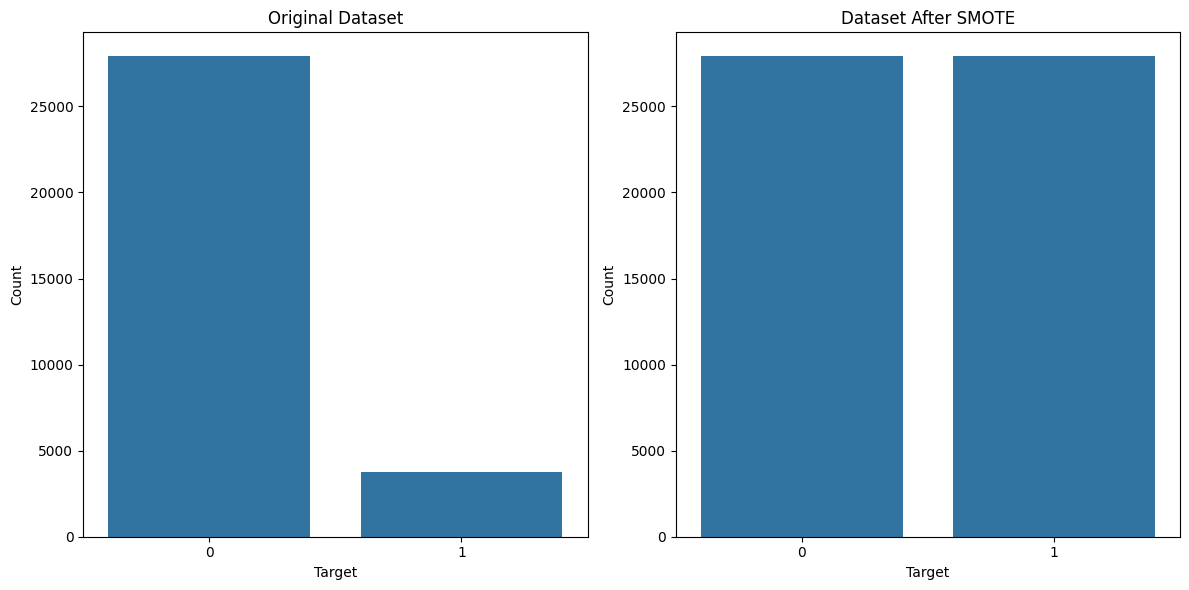

In [39]:
X_train, X_test, y_train, y_test = manual_split(df1, target_column='y')

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Plot the dataset before and after SMOTE
plot_dataset_before_after_smote(X_train, y_train, X_resampled, y_resampled)


In [40]:
# Convert the resampled X and y arrays into a DataFrame
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame({'y': y_resampled})], axis=1)

# Export the DataFrame to a CSV file
resampled_df.to_csv('bank_resampled_dataset.csv', index=False)


## Random Forest (Data Technique)

In [41]:
def model_selection():
    model = RandomForestClassifier()  
    print('Random Forest Classifier')  
    return model

In [42]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Random Forest Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.564
F1 -ve: 0.944
AUC: 0.928
Accuracy: 0.901

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.880
Fold 2: 0.964
Fold 3: 0.965
Fold 4: 0.966
Fold 5: 0.965

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.572
F1 -ve: 0.946
AUC: 0.928
Accuracy: 0.904


## Gradient Boosting (Data Technique)

In [43]:

def model_selection():
    model = GradientBoostingClassifier()  
    print('Gradient Boosting Classifier') 
    return model

In [44]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Gradient Boosting Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.576
F1 -ve: 0.929
AUC: 0.917
Accuracy: 0.878

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.844
Fold 2: 0.928
Fold 3: 0.932
Fold 4: 0.933
Fold 5: 0.929

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.576
F1 -ve: 0.929
AUC: 0.917
Accuracy: 0.878


## Naive Bayes (Data Technique)

In [45]:

def model_selection():
    model = GaussianNB() 
    print('Naive Bayes') 
    return model

In [46]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Naive Bayes

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.420
F1 -ve: 0.874
AUC: 0.785
Accuracy: 0.793

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.741
Fold 2: 0.753
Fold 3: 0.751
Fold 4: 0.756
Fold 5: 0.751

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.420
F1 -ve: 0.874
AUC: 0.785
Accuracy: 0.793


## Logistic Regression (Data Technique)

In [47]:

def model_selection():
    model = LogisticRegression()  
    print('Logistic Regression') 
    return model

In [48]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Logistic Regression

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.541
F1 -ve: 0.906
AUC: 0.907
Accuracy: 0.844

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.840
Fold 2: 0.849
Fold 3: 0.850
Fold 4: 0.854
Fold 5: 0.847

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.541
F1 -ve: 0.906
AUC: 0.907
Accuracy: 0.844


## Decision Trees (Data Technique)

In [49]:

def model_selection():
    model = DecisionTreeClassifier()  
    print('Decision Tree Classifier') 
    return model

In [50]:
master_pipeline_with_smote(filepath, target)

C:\Users\uzairmuh\AppData\Local\Temp\ipykernel_3096\185193881.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


Decision Tree Classifier

Training model without cross-validation...

Results without Cross-Validation:
F1 +ve: 0.496
F1 -ve: 0.926
AUC: 0.733
Accuracy: 0.871

Training and evaluating model with cross-validation...

Cross-Validation Scores:
Fold 1: 0.839
Fold 2: 0.926
Fold 3: 0.927
Fold 4: 0.927
Fold 5: 0.931

Training model with all data...

Evaluating model with all data...

Results with All Data:
F1 +ve: 0.501
F1 -ve: 0.927
AUC: 0.737
Accuracy: 0.872


## Results

### Class Imbalance - (Data Techniques)
|          | Logistic Regression | Naïve Bayes | Decision Tree | Random Forest Classifier | Gradient Boosting |
|------------------------|---------------------|-------------|---------------|--------------------------|-------------------|
| F1 +ve                 | 0.541               | 0.420       | 0.499         | 0.571                    | 0.576             |
| F1-ve                  | 0.906               | 0.874       | 0.926         | 0.944                    | 0.929             |
| AUC                    | 0.907               | 0.785       | 0.736         | 0.929                    | 0.917             |
| Accuracy               | 0.844               | 0.793       | 0.872         | 0.901                    | 0.878             |


# 1